# Modelling for Clustering and Segementation

This notebook focuses on clustering the customers on the basis of Recency (R), Frequence (F) and Monetary (M) features to identify various customer segements. 

In [194]:
%load_ext dotenv
%dotenv

# Import necessary libraries
import os
from pathlib import Path

import datetime as dt
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

# Set package options
np.random.seed(42)                  # set random seed for reproducibility
sns.set_theme(style="whitegrid")    # set seaborn style
set_config(transform_output='pandas')

### Utility Functions (TODO: move to /src/utils)

Call one or more of these reusable functions, as suited to the need, instead of rewriting inline code.  

In [225]:
# Function to visualize RFM distributions
def plot_rfm_distributions(rfm_data, title_suffix='', bins=30):
    '''Visualize distributions of RFM metrics
    Parameters:
        rfm_data (DataFrame): DataFrame containing RFM metrics
        title_suffix (str): Suffix to add to the plot titles
    Returns:
        None
    '''
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(rfm_data['Recency'], bins=bins, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Recency Distribution {title_suffix}')
    sns.histplot(rfm_data['Frequency'], bins=bins, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f'Frequency Distribution {title_suffix}')
    sns.histplot(rfm_data['Monetary'], bins=bins, kde=True, ax=axes[2], color='lightgreen')
    axes[2].set_title(f'Monetary Distribution {title_suffix}')
    plt.tight_layout()
    plt.show()

# Function to create boxplot for detecting outliers
def plot_rfm_boxplots(df, r_col='Recency', f_col='Frequency', m_col='Monetary'):
    cols = [r_col, f_col, m_col]
    titles = ["Recency", "Frequency", "Monetary"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, col, title in zip(axes, cols, titles):
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()


# Visualize clusters in 3D space
def plot_3d_clusters(rfm_data, rfm_scaled_data, kmeans_model):
    '''Visualize clusters in 3D space
    Parameters:
        rfm_data (DataFrame): Original RFM DataFrame with cluster labels
        rfm_scaled_data (DataFrame): Scaled RFM DataFrame
        kmeans_model (KMeans): Fitted KMeans model
    Returns:
        None
    '''
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        rfm_scaled_data['Recency'],
        rfm_scaled_data['Frequency'],
        rfm_scaled_data['Monetary'],
        c=rfm_data['Cluster'],
        cmap='viridis',
        s=50,
        alpha=0.6
    )

    # Plot cluster centers
    centers = kmeans_model.cluster_centers_
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        c='red',
        s=200,
        marker='X',
        label='Centroids'
    )

    ax.set_title('3D Visualization of Customer Clusters')
    ax.set_xlabel('Recency (scaled)')
    ax.set_ylabel('Frequency (scaled)')
    ax.set_zlabel('Monetary (scaled)')
    ax.legend()
    plt.tight_layout()
    plt.show()

import plotly.graph_objects as go

def plot_3d_clusters_plotly(rfm_data, rfm_scaled_data, kmeans_model):
    """
    Interactive 3D visualization of KMeans customer clusters using Plotly.

    Parameters:
        rfm_data (DataFrame): Original RFM DataFrame with cluster labels
        rfm_scaled_data (DataFrame): Scaled RFM DataFrame
        kmeans_model (KMeans): Fitted KMeans model

    Returns:
        Plotly interactive 3D scatter plot
    """

    # Extract cluster centers from the trained model
    centers = kmeans_model.cluster_centers_

    fig = go.Figure()

    # Add data points
    fig.add_trace(go.Scatter3d(
        x=rfm_scaled_data['Recency'],
        y=rfm_scaled_data['Frequency'],
        z=rfm_scaled_data['Monetary'],
        mode='markers',
        marker=dict(
            size=6,
            color=rfm_data['Cluster'],  # Cluster color
            opacity=0.7,
            colorscale='Viridis'
        ),
        text=[f"Customer: {i}<br>Cluster: {c}"
              for i, c in zip(rfm_data.index, rfm_data['Cluster'])],
        hovertemplate=
            "<b>%{text}</b><br><br>" +
            "Recency: %{x:.2f}<br>" +
            "Frequency: %{y:.2f}<br>" +
            "Monetary: %{z:.2f}<extra></extra>",
        name="Customer Points"
    ))

    # Add cluster centroids
    fig.add_trace(go.Scatter3d(
        x=centers[:, 0],
        y=centers[:, 1],
        z=centers[:, 2],
        mode='markers',
        marker=dict(
            size=12,
            color='red',
            symbol='x'
        ),
        name="Cluster Centroids"
    ))

    # Update layout
    fig.update_layout(
        title="Interactive 3D Customer Segmentation (RFM Clusters)",
        scene=dict(
            xaxis_title="Recency (scaled)",
            yaxis_title="Frequency (scaled)",
            zaxis_title="Monetary (scaled)"
        ),
        height=700,
        legend=dict(x=0.7, y=0.95)
    )

    fig.show()


### Load Recency (R), Frequence (F), Monetary (M) data

Load the RFM dataset previously created. 

In [196]:
# Load the prepared RFM data
rfm = pd.read_csv('../data/prepared/rfm.csv')

# Display basic information and descriptive statics
print(rfm.head())
print(rfm.info())
print(rfm.describe())

# Notes: RFM features show substantial variablity (see output below)

   CustomerID  Recency  Frequency  Monetary         Country Customer_Region
0       12346      325          1  77183.60  United Kingdom        Domestic
1       12347        1          7   4310.00         Iceland   International
2       12348       74          4   1797.24         Finland   International
3       12349       18          1   1757.55           Italy   International
4       12350      309          1    334.40          Norway   International
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       4341 non-null   int64  
 1   Recency          4341 non-null   int64  
 2   Frequency        4341 non-null   int64  
 3   Monetary         4341 non-null   float64
 4   Country          4341 non-null   object 
 5   Customer_Region  4341 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 203.6+ KB
None
 

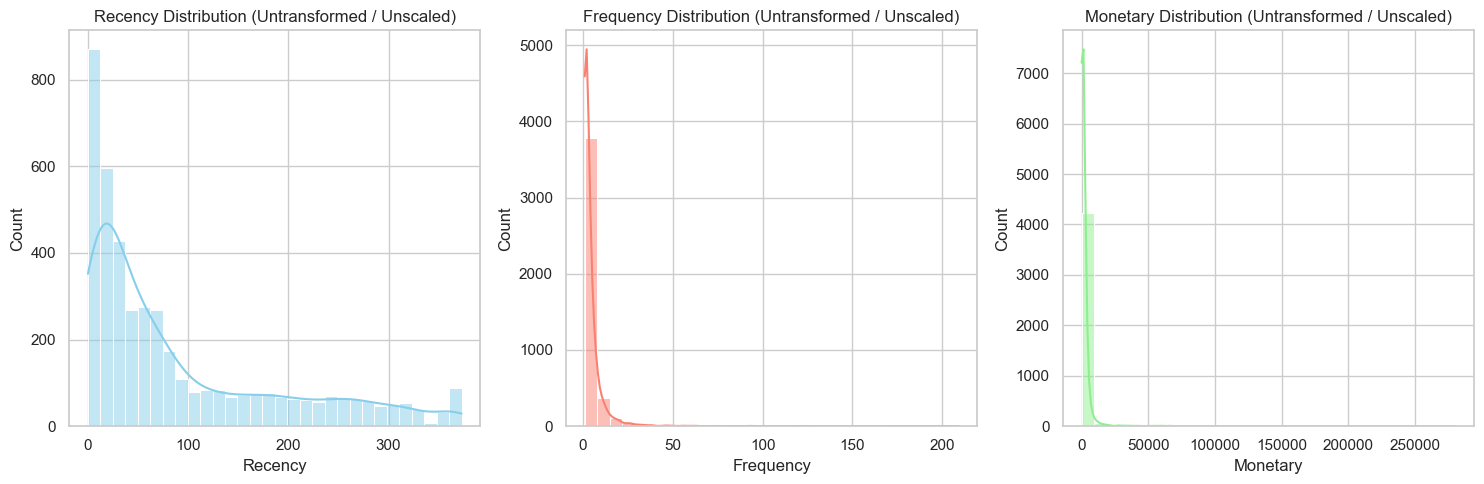

In [197]:
# Visualize RFM distributions for untransformed and unscaled data
plot_rfm_distributions(rfm, title_suffix='(Untransformed / Unscaled)')

### Standardization / scaling

Upon inspection of the RFM data a few issues were found, that would require some transformation and scaling of the dataset prior to cluserting using K-Means. RFM features are on different scales and greatly skewed. Clustering algorithms like KMeans are distance-based and sensitive to scale. For transformation, log1p (natural log on x+1) is applied to reduce skewness. After transformation, for scaling, StandardScaler (zero mean, unit variance) so features contribute equally to distance. Altenatively, RobustScaler can be considered (needs more investigation). log1p reduces heavy right skew while preserving order; StandardScaler centers and scales features for distance computations in KMeans. 

In [204]:
# Apply log transformation to RFM metrics to reduce skewness
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))
print(f'After log-transformation: \n', rfm_log.describe())
#plot_rfm_distributions(rfm_log, title_suffix='(Log-Transformed)')

After log-transformation: 
            Recency    Frequency     Monetary
count  4341.000000  4341.000000  4341.000000
mean      3.765764     1.346680     6.590871
std       1.432317     0.683497     1.259377
min       0.000000     0.693147     1.558145
25%       2.890372     0.693147     5.728638
50%       3.931826     1.098612     6.512978
75%       4.955827     1.791759     7.416559
max       5.924256     5.347108    12.543284


In [205]:
# Standardize the log-transformed RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(f'After scaling: \n', rfm_scaled.describe())

After scaling: 
             Recency     Frequency      Monetary
count  4.341000e+03  4.341000e+03  4.341000e+03
mean   9.166181e-17 -6.383591e-17  3.339109e-16
std    1.000115e+00  1.000115e+00  1.000115e+00
min   -2.629445e+00 -9.562699e-01 -3.996663e+00
25%   -6.112429e-01 -9.562699e-01 -6.847298e-01
50%    1.159523e-01 -3.629802e-01 -6.185802e-02
75%    8.309614e-01  6.512550e-01  6.557070e-01
max    1.507167e+00  5.853555e+00  4.727017e+00


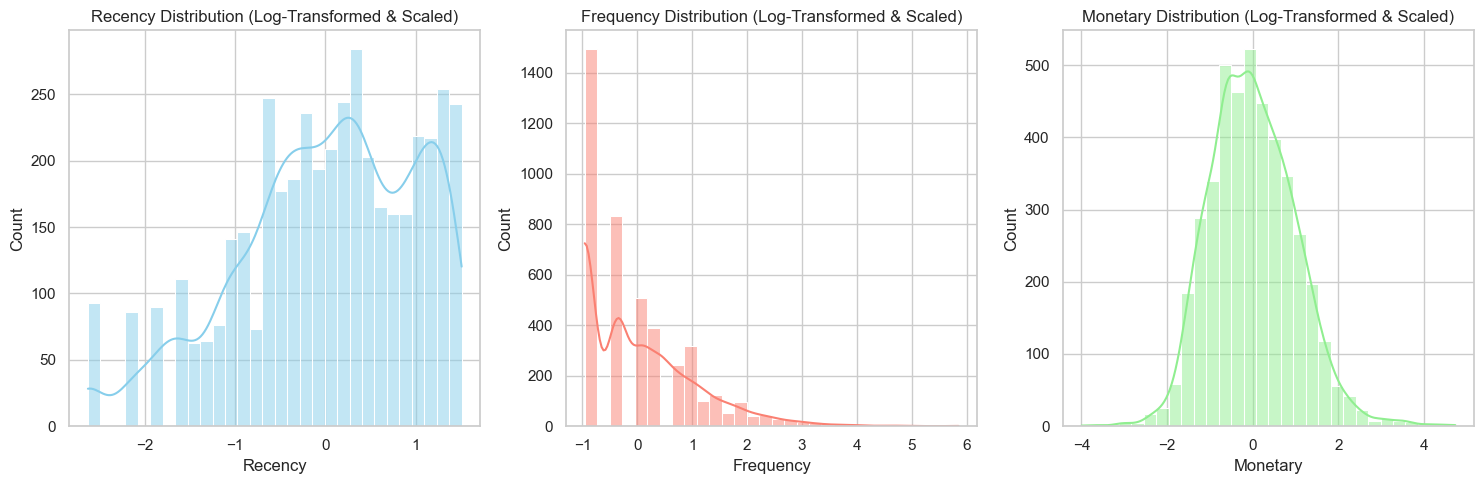

In [206]:
# Visualize RFM distributions for log-transformed and scaled data
plot_rfm_distributions(rfm_scaled, title_suffix='(Log-Transformed & Scaled)')

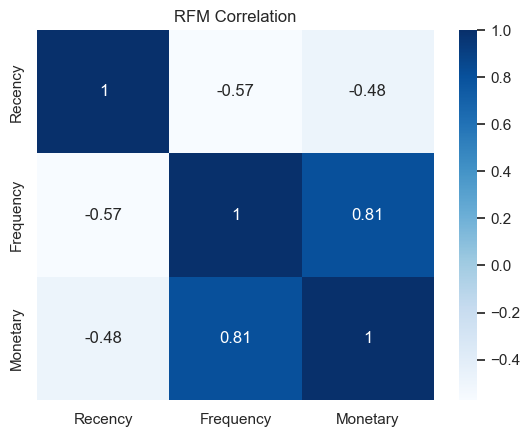

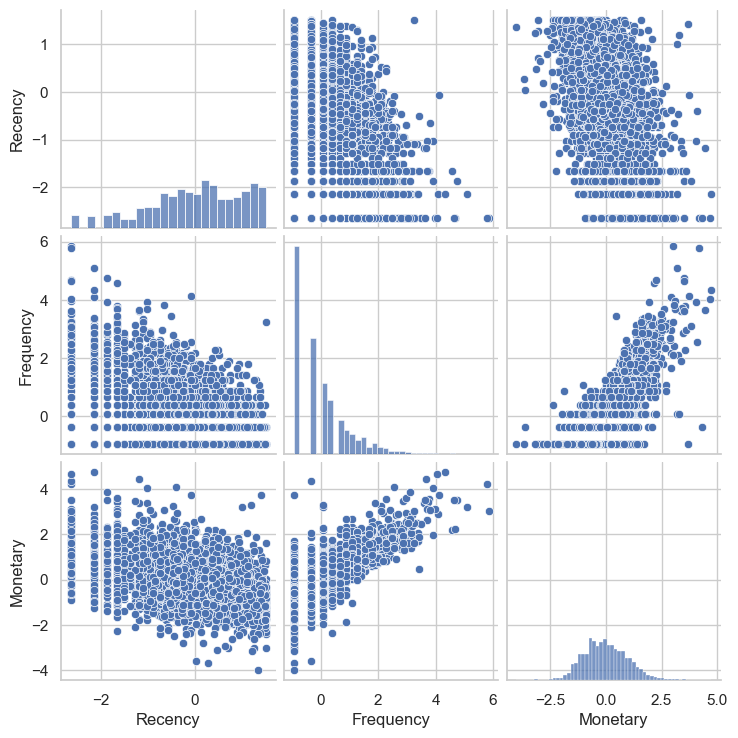

In [209]:
# Plot a correlation heatmap for RFM (transformed and scaled)
sns.heatmap(rfm_scaled[['Recency','Frequency','Monetary']].corr(), annot=True, cmap='Blues')
plt.title("RFM Correlation")
plt.show()


# Plot pairwise plot for RFM (transformed and scaled) data
sns.pairplot(rfm_scaled[['Recency','Frequency','Monetary']])
plt.show()

# Insights:
# Recency has -ive corr vs. F and M
# Frequency and Monetary have strong +ive corr

### Apply the K-Mean clustering

Apply K-Means clustering using Scikit Learn, and evaluate using: (i) the 'Elbow' method (inertia vs k), and (ii) check stability by visulizing the Silhouette Score (higher is better). 

In [210]:
sse = []    # Sum of Squres Error's for various k values (WSSD's)
sil = []    # Silhouette scores for various k values (Read more here: https://en.wikipedia.org/wiki/Silhouette_(clustering))

k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans = kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    sil.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Display the numbers
clusters = pd.DataFrame({'k-value': k_range, 'sse / wssd score': sse, 'silhouette score': sil})
clusters


,k-value,sse / wssd score,silhouette score
0,2,6504.424124,0.435716
1,3,4895.143691,0.338639
2,4,3989.685482,0.338069
3,5,3382.336752,0.309617
4,6,2898.412208,0.313784
5,7,2615.755684,0.305851
6,8,2401.753399,0.274835
7,9,2201.987400,0.277752
8,10,2041.949000,0.277745


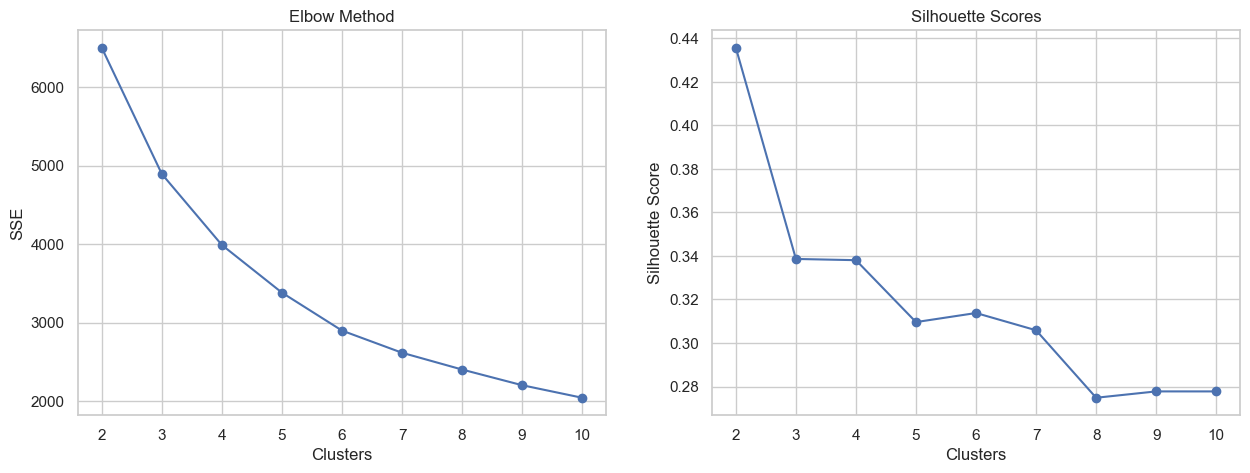

In [211]:
# Plot Elbow and Silhouette visualizations for selection of best k-value
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("SSE")

plt.subplot(1,2,2)
plt.plot(k_range, sil, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.show()

### Train final model

In [233]:
# Train the final model using the best value of k

final_k = 5
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=20)
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region,Cluster
0,12346,325,1,77183.60,United Kingdom,Domestic,1
1,12347,1,7,4310.00,Iceland,International,0
2,12348,74,4,1797.24,Finland,International,1
3,12349,18,1,1757.55,Italy,International,4
4,12350,309,1,334.40,Norway,International,2


In [237]:
# Create a cluster profile with mean of each RFM feature and cluser size

cluster_profile = (
    rfm.groupby("Cluster")
    .agg({"Recency":"mean", "Frequency":"mean", "Monetary":"mean", "CustomerID":"count"})
    .rename(columns={"CustomerID":"Count"})
)

cluster_profile


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,17.951595,6.447745,2492.041397,909
1,98.157846,3.144847,1446.621851,1077
2,200.939730,1.206979,276.657075,1261
3,8.925000,22.817857,15702.869679,280
4,23.212531,1.733415,415.933600,814


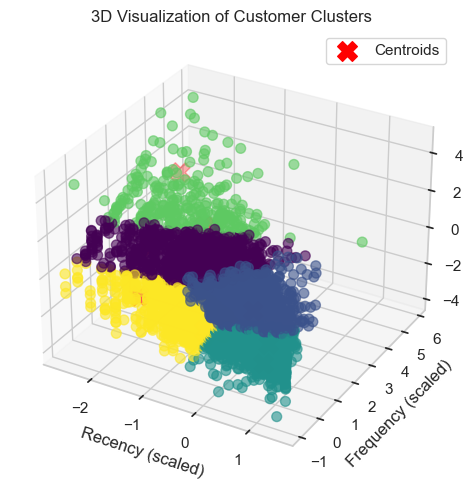

In [224]:
plot_3d_clusters(rfm, rfm_scaled, kmeans)

In [ ]:
# TODO: Sementation 